# Inference

In this notebook, we will use the trained model to generate captions for images in the test dataset.


In [1]:
from PIL import Image
import torch
import math
from torchvision import transforms
from model import *
from nlp_utils import clean_sentence
import os
import pickle
import matplotlib.pyplot as plt

import requests
from io import BytesIO
import urllib.parse

/home/farid/miniconda3/envs/py39/lib/python3.9/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: '/home/farid/miniconda3/envs/py39/lib/python3.9/site-packages/torchvision/image.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
HOME: str = os.getenv('HOME') # echo $HOME
USER: str = os.getenv('USER') # echo $USER

if USER=="alijanif":
	WDIR = "/scratch/project_2004072/IMG_Captioning"
	cocoapi_dir = os.path.join(WDIR, "MS_COCO")
	models_dir = os.path.join(WDIR, "trash", "models")
else:
	WDIR = "datasets"
	cocoapi_dir = os.path.join(HOME, WDIR, "MS_COCO")
	models_dir = os.path.join(HOME, WDIR, "trash", "models")

In [3]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

# Set the necessary parameters
embed_size = 256  # Assuming it's the same as during training
hidden_size = 512  # Assuming it's the same as during training
vocab_file = "vocab.pkl"  # Assuming the name of the vocabulary file

# Load the vocabulary
with open(os.path.join("./data", vocab_file), "rb") as f:
    vocab = pickle.load(f)

vocab_size = len(vocab)

# Initialize the encoder and decoder.
encoder = EncoderCNN(embed_size)
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)

# Moving models to the appropriate device
encoder.to(device)
decoder.to(device)

Using Device: cuda


DecoderRNN(
  (embed): Embedding(11543, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=11543, bias=True)
)

In [4]:
num_epochs = 3  # training epochs
encoder_fname = f"encoder_{num_epochs}_nEpochs.pkl"
decoder_fname = f"decoder_{num_epochs}_nEpochs.pkl"

print(f"Encoder fpath: {os.path.join(models_dir, encoder_fname)}")
print(f"Decoder fpath: {os.path.join(models_dir, decoder_fname)}")

# Loading the trained weights
encoder.load_state_dict(torch.load(os.path.join(models_dir, encoder_fname)))
decoder.load_state_dict(torch.load(os.path.join(models_dir, decoder_fname)))

# Set models to evaluation mode
encoder.eval()
decoder.eval()

Encoder fpath: /home/farid/datasets/trash/models/encoder_3_nEpochs.pkl
Decoder fpath: /home/farid/datasets/trash/models/decoder_3_nEpochs.pkl


DecoderRNN(
  (embed): Embedding(11543, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=11543, bias=True)
)

In [5]:
tst_img_dir = "TEST_IMGs"

In [6]:
def generate_caption(img_source: str = os.path.join(tst_img_dir, "baseball.jpeg")):
    # Check if the input is a URL or local path
    is_url = urllib.parse.urlparse(img_source).scheme != ""

    if is_url:
        # If it's a URL, download the image
        response = requests.get(img_source)
        test_image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        # If it's a local path, open the image directly
        test_image = Image.open(img_source).convert("RGB")

    # Apply transformations to the test image
    transform_test = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize(
            (0.485, 0.456, 0.406),
            (0.229, 0.224, 0.225),
        ),
    ])

    # Preprocess the test image
    test_image_tensor = transform_test(test_image).unsqueeze(0)  # Add batch dimension

    # Move the preprocessed image to the appropriate device
    test_image_tensor = test_image_tensor.to(device)

    # Pass the test image through the encoder
    with torch.no_grad():
        features = encoder(test_image_tensor).unsqueeze(1)

    # Generate captions with the decoder
    with torch.no_grad():
        output = decoder.sample(features)

    # Convert the output into a clean sentence
    caption = clean_sentence(output, vocab.idx2word)

    # Display the test image with the generated caption
    plt.imshow(test_image)
    plt.axis('off')
    plt.title(caption)
    plt.show()

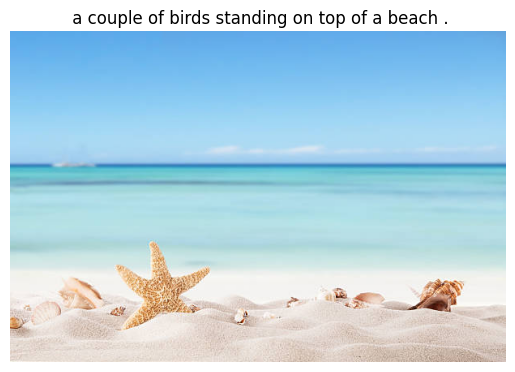

In [16]:
generate_caption(
  # img_source="https://www.thenexttrip.xyz/wp-content/uploads/2022/08/San-Diego-Instagram-Spots-2-820x1025.jpg" # beach lady
  # img_source="https://www.sunnylife.com.au/cdn/shop/articles/Instagram_1068_1024x1024.jpg" # beach lady checking phone
  # img_source="https://d3h7nocoh5wnls.cloudfront.net/medium_65f863d2b8a8f574defc0222_Cowgirl_20_Instagram_20_Captions_20_8_e9b3ef13bc.webp" # standing woman holding rope
  # img_source="https://d3h7nocoh5wnls.cloudfront.net/medium_65f863d2b8a8f574defc058b_One_Word_Joshua_Tree_Captions_0bc104498d.webp"
  # img_source="https://hips.hearstapps.com/hmg-prod/images/beach-summer-instagram-captions-1621880365.jpg" # wonderful result
  img_source="https://media.istockphoto.com/id/498168409/photo/summer-beach-with-strafish-and-shells.jpg?s=612x612&w=0&k=20&c=_SCAILCSzeekYQQAc94-rlAkj7t_1VmiqOb5DmVo_kE="
  # img_source="baseball.jpeg"
)

In [8]:
def generate_captions(img_sources: list):
    def load_image(img_source):
        is_url = urllib.parse.urlparse(img_source).scheme != ""
        if is_url:
            response = requests.get(img_source)
            return Image.open(BytesIO(response.content)).convert("RGB")
        else:
            return Image.open(img_source).convert("RGB")

    transform_test = transforms.Compose([
        transforms.Resize(224),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])

    captions = []
    images = []

    for img_source in img_sources:
        img = load_image(img_source)
        images.append(img)
        
        img_tensor = transform_test(img).unsqueeze(0).to(device)
        
        with torch.no_grad():
            features = encoder(img_tensor).unsqueeze(1)
            output = decoder.sample(features)
        
        caption = clean_sentence(output, vocab.idx2word)
        captions.append(caption)

    # Calculate grid dimensions
    n_images = len(images)
    n_cols = min(5, n_images)
    n_rows = math.ceil(n_images / n_cols)

    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 4*n_rows))
    fig.suptitle("Generated Captions", fontsize=13)

    for i, (img, caption) in enumerate(zip(images, captions)):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col] if n_rows > 1 else axes[col]
        
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(caption, wrap=True)

    # Remove empty subplots
    for i in range(n_images, n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        fig.delaxes(axes[row, col] if n_rows > 1 else axes[col])

    plt.tight_layout()
    plt.show()

In [11]:
IMGs_list = [
  "https://www.thenexttrip.xyz/wp-content/uploads/2022/08/San-Diego-Instagram-Spots-2-820x1025.jpg", # beach lady
  "https://www.sunnylife.com.au/cdn/shop/articles/Instagram_1068_1024x1024.jpg", # beach lady checking phone
  "https://d3h7nocoh5wnls.cloudfront.net/medium_65f863d2b8a8f574defc0222_Cowgirl_20_Instagram_20_Captions_20_8_e9b3ef13bc.webp", # standing woman holding rope
  os.path.join(tst_img_dir, "beach_holding_drink.JPG"),
  os.path.join(tst_img_dir, "surf.jpeg"),
  os.path.join(tst_img_dir, "skiing.jpg"),
  os.path.join(tst_img_dir, "enjoying_sun.jpg"),
  os.path.join(tst_img_dir, "jet.jpg"),
  os.path.join(tst_img_dir, "smoking_reading.jpg"),
  os.path.join(tst_img_dir, "reindeers.jpg"),
]

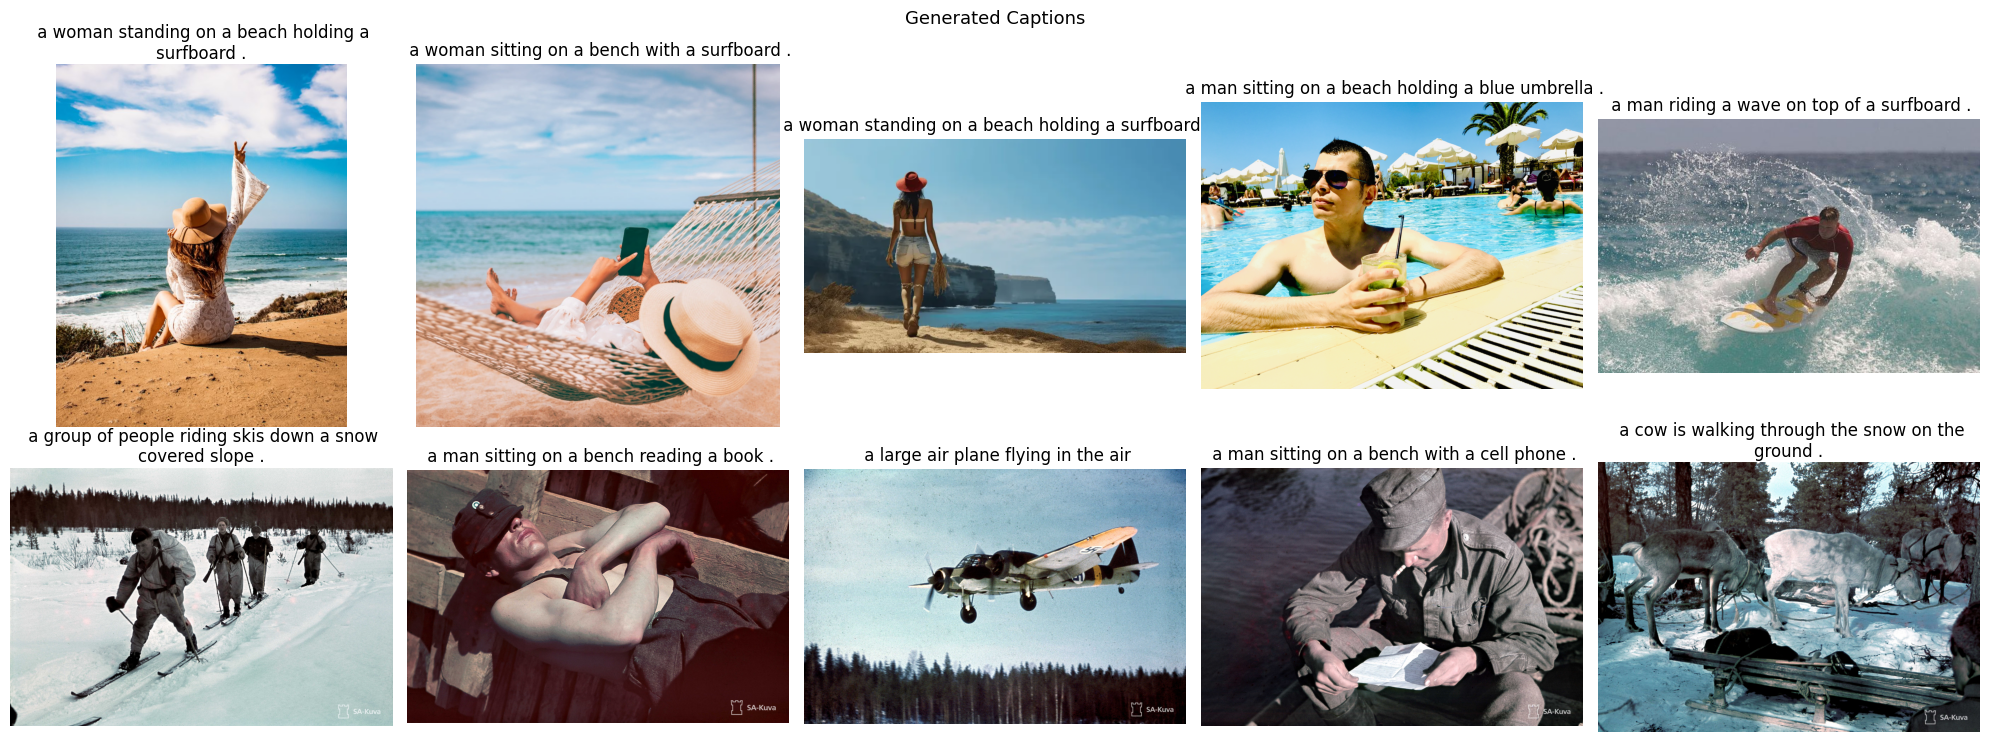

In [12]:
generate_captions(
  img_sources=IMGs_list
)